In [1]:
import json
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import precision_score
import numpy as np
import random
import gzip
import dateutil.parser
import math
import matplotlib.pyplot as plt
import string
import re
from nltk.stem.snowball import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from wordcloud import WordCloud, STOPWORDS
import statistics

In [2]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))

In [3]:
len(dataset)

192544

In [4]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## Data Cleaning

In [5]:
data = dataset

In [6]:
# Drop all ratings having null values
data = [d for d in dataset if d['rating'] != None]
print(len(data), len(dataset))

192462 192544


In [7]:
# Drop all 'age' having null values
data = [d for d in data if 'age' in d]
print(len(data), len(dataset))

191503 192544


In [8]:
# Drop all 'weight' having null values
data = [d for d in data if 'weight' in d]
print(len(data), len(dataset))

162153 192544


In [9]:
# Drop all 'height' having null values
data = [d for d in data if 'height' in d]
print(len(data), len(dataset))

161716 192544


In [10]:
# Drop all 'body type' having null values
data = [d for d in data if 'body type' in d and d['body type'] != None]
print(len(data), len(dataset))

153110 192544


In [11]:
# Drop all 'rented for' having null values
data = [d for d in data if 'rented for' in d and d['body type'] != None]
print(len(data), len(dataset))

153100 192544


In [12]:
for d in data:
    # Convert 'rating' from string to int and change from 2,4,6,8,10 to 1,2,3,4,5
    d['rating'] = int(d['rating']) // 2
    # Convert 'age' from string to int
    d['age'] = int(d['age'])
    # Drop 'lbs' unit and convert 'weight' from str to int
    d['weight'] = int(d['weight'][:-3])
    # Drop unit and convert 'height' from str to int
    feet,inch = re.findall(r'\d+', d['height'])
    d['height'] = int(feet) * 12 + int(inch)

In [13]:
# Pre-processing 'review_text' by ignoring capitalization and removing punctuation
sp = set(string.punctuation)
def cleanText(text):
    text = ''.join([c for c in text.lower() if not c in sp])
    return text

In [14]:
data[68]

{'fit': 'fit',
 'user_id': '203660',
 'bust size': '34c',
 'item_id': '1126889',
 'weight': 160,
 'rating': 3,
 'rented for': 'party',
 'review_text': "The dress is absolutely gorgeous, unfortunately the dress proportions were off for my height. I would have loved to wear this out, but I couldn't because the lengths were awkward on my body. ",
 'body type': 'athletic',
 'review_summary': 'Too Long',
 'category': 'dress',
 'height': 64,
 'size': 12,
 'age': 28,
 'review_date': 'January 3, 2017'}

In [15]:
print(len(data), len(dataset)) 

153100 192544


In [50]:
def plotDistPie(figSize, countsPerItem, title):
    labelCounts = [(k, v) for k, v in countsPerItem.items()]
    labels = [labelCounts[i][0] for i in range(len(labelCounts))]
    counts = [labelCounts[i][1] for i in range(len(labelCounts))]
    countSum = sum(counts)
    countPercentage = [c / countSum * 100 for c in counts]
    explode = (0.1, 0, 0)

    plt.figure(figsize=figSize)
    _, _, autotexts = plt.pie(countPercentage, explode=explode, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen'])
    for autotext in autotexts:
        autotext.set_color('white')
    plt.title(title)
    plt.show()

In [28]:
def plotScatter(figSize, color, x, y, xleft, xright, xlabel, ylabel, title):
    plt.figure(figsize=figSize)
    plt.scatter(x, y, color=color)
    plt.xlim(left=xleft, right=xright)
    plt.xlabel(xlabel)
    plt.ylabel('Rating')
    plt.title(title)
    plt.show()

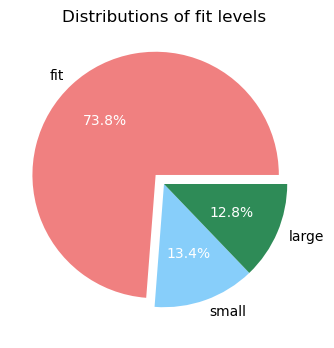

In [51]:
# Distribution of fit levels
countsPerFit = defaultdict(int)
for d in dataset:
    countsPerFit[d['fit']] += 1

plotDistPie((6, 4), countsPerFit, 'Distributions of fit levels')

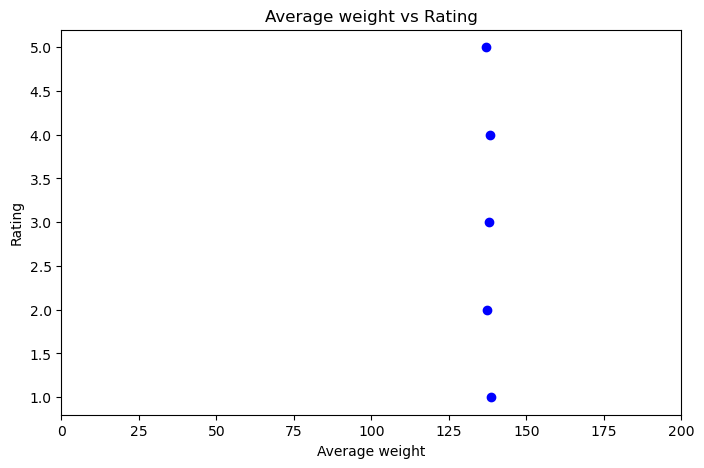

In [19]:
pts = []
weightsPerRating = defaultdict(list)

for d in data:
    weightsPerRating[d['rating']].append(d['weight'])

for k, v in weightsPerRating.items():
    pts.append((statistics.mean(v), k))

labels = [pt[0] for pt in pts]
counts = [pt[1] for pt in pts]
plotScatter((8, 5), 'blue', labels, counts, 0, 200, 'Average weight', 'Rating', 'Average weight vs Rating')

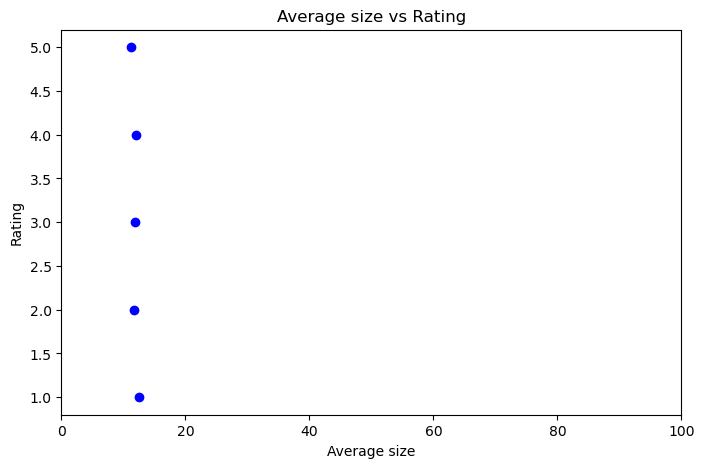

In [20]:
pts = []
sizesPerRating = defaultdict(list)

for d in data:
    sizesPerRating[int(d['rating'])].append(float(d['size']))

for k, v in sizesPerRating.items():
    pts.append((statistics.mean(v), k))

labels = [pt[0] for pt in pts]
counts = [pt[1] for pt in pts]
plotScatter((8, 5), 'blue', labels, counts, 0, 100, 'Average size', 'Rating', 'Average size vs Rating')

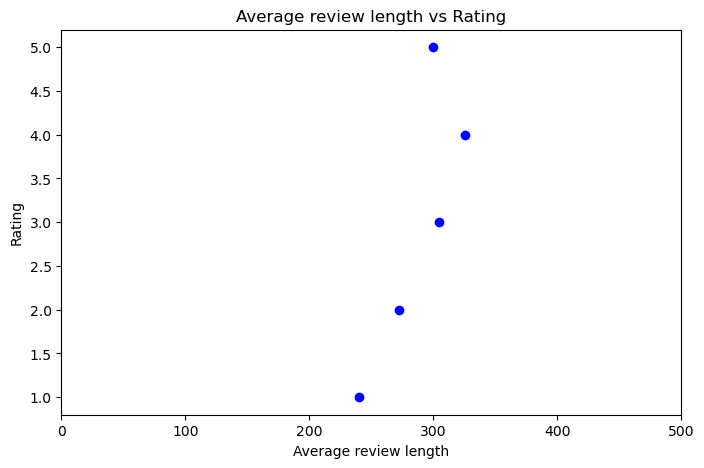

In [21]:
pts = []
reviewLensPerRating = defaultdict(list)

for d in data:
    reviewLensPerRating[int(d['rating'])].append(float(len(d['review_text'])))

for k, v in reviewLensPerRating.items():
    pts.append((statistics.mean(v), k))

labels = [pt[0] for pt in pts]
counts = [pt[1] for pt in pts]
plotScatter((8, 5), 'blue', labels, counts, 0, 500, 'Average review length', 'Rating', 'Average review length vs Rating')

## Wordcloud

In [22]:
text = [cleanText(d['review_text']) for d in data]
random.shuffle(text)
r_text = random.sample(text, 10000)

In [23]:
wc = ' '
for w in r_text:
    wc += w

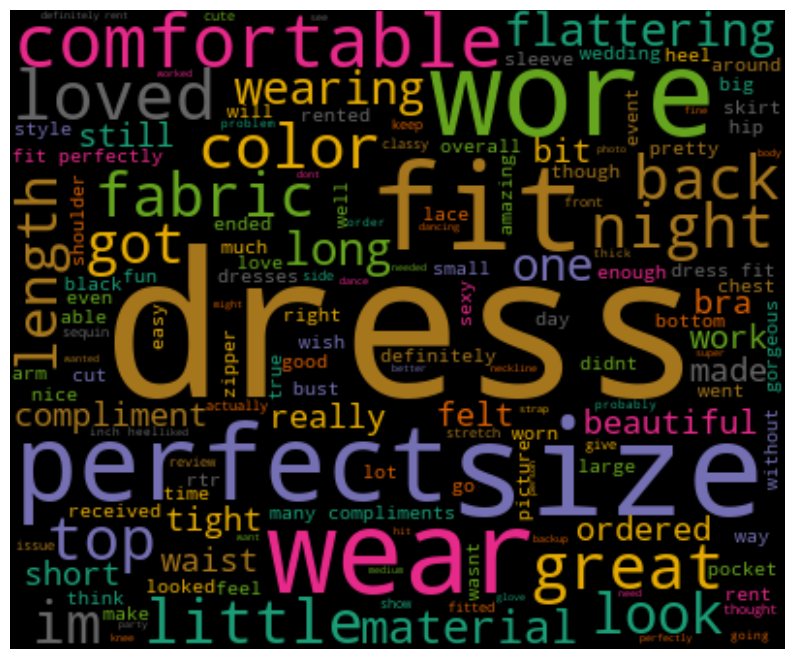

In [24]:
wordcloud = WordCloud(width=400, height=330, stopwords = set(STOPWORDS), max_words=150,colormap="Dark2").generate(wc)
fig = plt.figure(figsize=(10, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()